In [1]:
import pandas as pd
import numpy as np
import sys
import re
df_ordered = pd.read_csv("../code/ordered.csv")
df_severeWeather = pd.read_csv("../code/severeWeather.csv")

# Capstone Project I Report: Data Storytelling Part 2

From the previous report we conclude the following:

* The sales pattern of normal days is different from the sales pattern of extreme weather period.
* Item 5 sells best during extreme weather period.
* Features that indicating whether the day is a normal day, a day before a bad weather or a day after a bad weather could be useful since observation suggests that even when it is a sunny day, the sales record close to bad weather still differ from normal case.

In this report, I would like to analyze the second point further. The target for this project is predicting product sales in major weather events. Since the model performance will be judged by learning error, and the best selling item during major weather events is likely to be the most dominant factor in the learning error if the model makes the wrong prediction, it would be useful to analyze which features are more dominant in predicting item 5 sales. By such analysis, Hopefully, I would be able to select the appropriate learning model to start the learning process.

It does seem that all the features in this dataset could affect sales record in some ways. For example, under heavy rains or high-temperature people may delay their shopping to another day. Also, people tend to buy more things on weekends instead of weekdays. In order to answer which feature is more dominant in terms of determining people's shopping pattern, I list the following questions to be tested:
* Specific idea on item 5: Given above, among these factors, which one can affect sales record?
    + year
    + month
    + weekdays
    + rainfall/snowfall
    + temperature

## Specific idea on item 5: 

<h4> Question: Given above, among these factors, which one can affect sales record? 1. year 2. month 3. weekdays 4. rainfall/snowfall 5. temperature 
</h4>

### Year

Let us first see how the sales record looks like on each year:

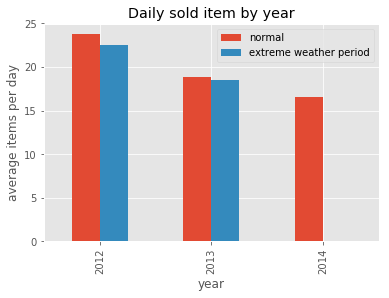

In [2]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

df_ordered['year'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.year

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','year']]

count = data.groupby(['year']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()


mask = ((df_ordered['item_nbr'] == 5) & (df_ordered['WEvent'] == 1))
data = df_ordered.loc[mask,['units','year']]

count_severe = data.groupby(['year']).aggregate(np.mean).unstack()
count_severe.index = count_severe.index.droplevel()

count = pd.concat([count, count_severe], axis=1)
count.columns = ['normal','extreme weather period']

count.plot(kind='bar')

plt.title('Daily sold item by year')
plt.xlabel('year')
plt.ylabel('average items per day')


plt.show()

From the above graph, we can see the sales record steady going down given the year, meaning that year does affect the sales record. However, we still need to perform inferential statistics to be sure.

Note that the 2014 record for item 5 is zero. There are actually three bad weather records for item 5 in 2014 but there is no item 5 sold at that time, see below:

In [3]:
mask = (df_ordered['date'] >= '2014-01-01') & (df_ordered['WEvent'] == 1) & (df_ordered['item_nbr'] == 5)

print df_ordered.loc[mask, ['date','store_nbr','item_nbr','units']]

               date  store_nbr  item_nbr  units
1318661  2014-02-10         14         5    0.0
1318662  2014-02-11         14         5    0.0
1318663  2014-02-12         14         5    0.0
1318664  2014-02-13         14         5    0.0
1318665  2014-02-14         14         5    0.0
1318666  2014-02-15         14         5    0.0
1318667  2014-02-16         14         5    0.0
1536120  2014-01-07         16         5    0.0
1536121  2014-01-08         16         5    0.0
1536122  2014-01-09         16         5    0.0
1840681  2014-01-10         19         5    0.0
1840682  2014-01-11         19         5    0.0
1840683  2014-01-12         19         5    0.0
4516460  2014-02-10         45         5    0.0
4516461  2014-02-11         45         5    0.0
4516462  2014-02-12         45         5    0.0
4516463  2014-02-13         45         5    0.0
4516464  2014-02-14         45         5    0.0
4516465  2014-02-15         45         5    0.0
4516466  2014-02-16         45         5

Given the previous record, it might be interesting to build our model based on all the records instead of using the records from weather events only.

### Month

Let us now turn to month:

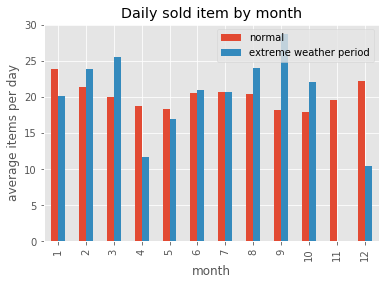

In [4]:
df_ordered['month'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.month

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','month']]

count = data.groupby(['month']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()


mask = ((df_ordered['item_nbr'] == 5) & (df_ordered['WEvent'] == 1))
data = df_ordered.loc[mask,['units','month']]

count_severe = data.groupby(['month']).aggregate(np.mean).unstack()
count_severe.index = count_severe.index.droplevel()

count = pd.concat([count, count_severe], axis=1)
count.columns = ['normal','extreme weather period']

count.plot(kind='bar')

plt.title('Daily sold item by month')
plt.xlabel('month')
plt.ylabel('average items per day')


plt.show()


The month record is more even and diverse. It is hard to see the pattern from this graph, although it can hide some useful information, but certainly not as explicit as the year can provide.

### Weekday

Let us see what weekday can provide:

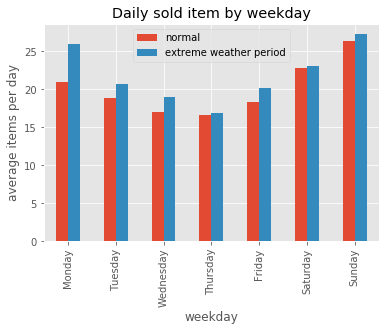

In [5]:
df_ordered['weekday'] = pd.to_datetime(df_ordered['date'], infer_datetime_format=True).dt.weekday

mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','weekday']]

count = data.groupby(['weekday']).aggregate(np.mean).unstack()
count.index = count.index.droplevel()


mask = ((df_ordered['item_nbr'] == 5) & (df_ordered['WEvent'] == 1))
data = df_ordered.loc[mask,['units','weekday']]

count_severe = data.groupby(['weekday']).aggregate(np.mean).unstack()
count_severe.index = count_severe.index.droplevel()

count = pd.concat([count, count_severe], axis=1)
count.columns = ['normal','extreme weather period']
import calendar
count.index = list(calendar.day_name)

count.plot(kind='bar')

plt.title('Daily sold item by weekday')
plt.xlabel('weekday')
plt.ylabel('average items per day')


plt.show()

Weekday is another easy observation. People tend to buy more on weekends. On weekdays, Monday and Friday see more selling than others.

### Rainfall/Snowfall

Let us see how rainfall/snowfall affect selling, first by plotting a scatterplot:

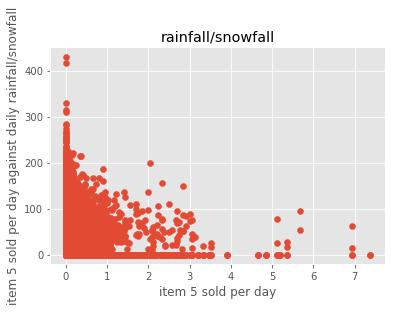

In [6]:
mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','preciptotal']]

plt.scatter(data['preciptotal'],data['units'])
plt.title('rainfall/snowfall')
plt.xlabel('item 5 sold per day')
plt.ylabel('item 5 sold per day against daily rainfall/snowfall')

plt.show()

It looks like people buy more when there is less rainfall/snowfall. But is it really? Scatterplot does not provide us more information, let us instead do a customized box plot:

[0.0, 0.02, 0.070000000000000007, 0.19, 0.46000000000000002, 7.3600000000000003]

for preciptotal range in 0.0
number of observations: 31569
value,  20.9697171276
99% interval,  [ 20.48870538  21.44956429]

for preciptotal range in 0.0 to 0.02
number of observations: 2086
value,  16.9247363375
99% interval,  [ 15.17974353  18.68794583]

for preciptotal range in 0.02 to 0.07
number of observations: 1797
value,  17.4663327769
99% interval,  [ 15.56148303  19.42459655]

for preciptotal range in 0.07 to 0.19
number of observations: 2086
value,  18.1687440077
99% interval,  [ 16.32837967  20.06472196]

for preciptotal range in 0.19 to 0.46
number of observations: 2000
value,  17.098
99% interval,  [ 15.34549    18.8960175]

for preciptotal range in 0.46 to 7.36
number of observations: 2062
value,  17.9427740058
99% interval,  [ 16.29386518  19.66586081]


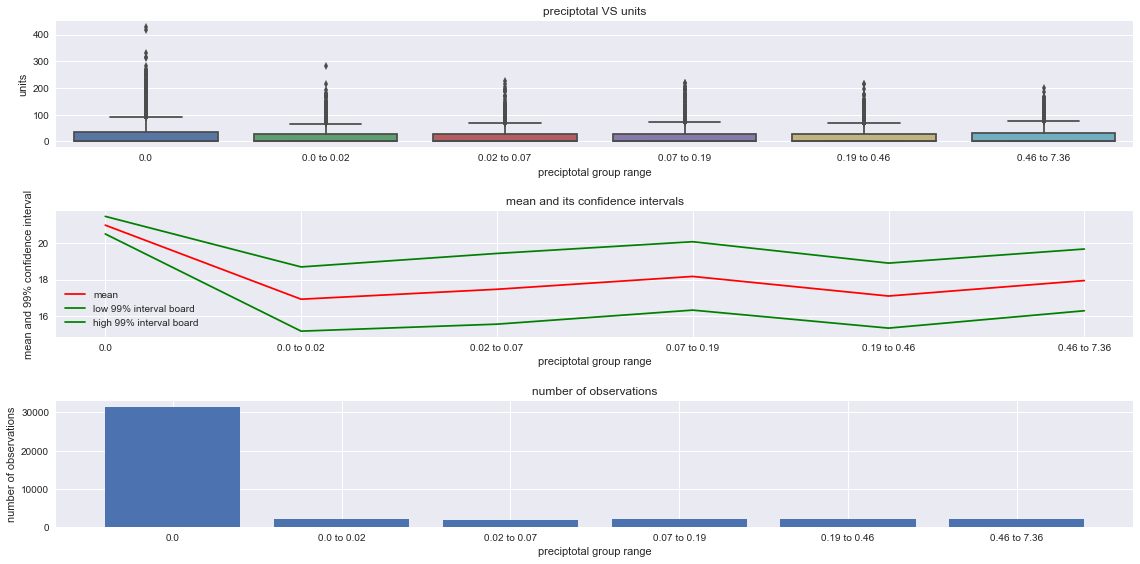

In [7]:
import seaborn as sns

def bsfromfunc(observes,targetfunc):
    value = targetfunc(observes)
    bs_target = np.empty(10000)
    for i in range(10000):
        bs_sample = np.random.choice(observes,size=len(observes))
        bs_target[i] = targetfunc(bs_sample)
        
    print 'value, ', value
    print '99% interval, ', np.percentile(bs_target, [0.5, 99.5])
    
    return value,np.percentile(bs_target, [0.5, 99.5])

def cont_boxplot(data,xlabel,ylabel,seg=10):
    data_range = np.percentile(data[xlabel], [100*float(x)/seg for x in range(seg+1)])
    data_range = sorted(list(set(data_range)))
    
    print data_range
    
    seg = len(data_range) - 1
    data['x_label']=str(data_range[seg-1])+' to '+str(data_range[seg])
    value = []
    value_interv_h = []
    value_interv_l = []
    number = []
    order = []
    
    data.loc[(data[xlabel]==data_range[0]),'x_label'] = str(data_range[0])
    obsers = data.loc[data['x_label']==str(data_range[0]),ylabel]
    print '\n'+'for '+xlabel+' range in '+str(data_range[0])
    print 'number of observations: '+str(len(obsers))
    t_value,t_interv = bsfromfunc(obsers,np.mean)
    value.append(t_value)
    value_interv_l.append(t_interv[0])
    value_interv_h.append(t_interv[1])
    number.append(len(obsers))
    order.append(str(data_range[0]))
    for i in range(seg):
        data.loc[(data[xlabel]>data_range[i])&(data[xlabel]<=data_range[i+1]),'x_label']=str(data_range[i])+' to '+str(data_range[i+1])
        obsers = data.loc[data['x_label']==str(data_range[i])+' to '+str(data_range[i+1]),ylabel]
        print '\n'+'for '+xlabel+' range in '+str(data_range[i])+' to '+str(data_range[i+1])
        print 'number of observations: '+str(len(obsers))
        t_value,t_interv = bsfromfunc(obsers,np.mean)
        value.append(t_value)
        value_interv_l.append(t_interv[0])
        value_interv_h.append(t_interv[1])
        number.append(len(obsers))
        order.append(str(data_range[i])+' to '+str(data_range[i+1]))
    f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,8))
    sns.boxplot(x='x_label',y=ylabel,data=data,ax=ax1,order=order)
    ax1.set_title(xlabel+' VS '+ylabel)
    ax1.set_xlabel(xlabel + ' group range')
    ax1.set_ylabel(ylabel)
    #ax1.set_xticklabels(data['x_label'],rotation='vertical')
    
    order.insert(0,'Somehow the set_xticklabel start from 1')
    ax2.plot(value,c='red', label='mean')
    ax2.plot(value_interv_l,c='green', label='low 99% interval board')
    ax2.plot(value_interv_h,c='green', label='high 99% interval board')
    ax2.plot()
    ax2.set_title('mean and its confidence intervals')
    ax2.set_xlabel(xlabel + ' group range')
    ax2.set_ylabel('mean and 99% confidence interval')
    ax2.set_xticklabels(order)
    ax2.legend()
    
    #ax2.plot(number)
    ax3.bar(np.array(np.arange(len(number))), np.array(number), width=0.8)
    ax3.set_xticklabels(order)
    ax3.set_title('number of observations')
    ax3.set_xlabel(xlabel + ' group range')
    ax3.set_ylabel('number of observations')  
    ax3.set_xticklabels(order)
    plt.tight_layout()
    plt.show()
    #return value, value_interv_l, value_interv_h
    
mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','preciptotal']]
cont_boxplot(data,'preciptotal','units',seg=20)

I apply a little inferential statistics here (99% confidence interval). From above plots two points can be concluded:
* When there is no rainfall/snowfall, people buy more item 5.
* However if there appears even a tiny bit of rain, people buy less item 5 instantly.
* There is little difference made from the amount of rainfall/snowfall. Meaning that many people do not just cancel their visit when the rain/snow gets larger. If you see it, the sales even go up a little bit as the precitotal gets higher. This possibly means that people prefer to stay at home at the sight of rain/snow, but whey actually wants to go shopping more if the rain/snow gets larger than 0.46 inches.

Let us see how the pattern change when the days are close to major weather events:

[0.0, 0.029999999999999999, 0.20000000000000001, 0.59999999999999998, 1.3999999999999999, 7.3600000000000003]

for preciptotal range in 0.0
number of observations: 1337
value,  22.7015706806
99% interval,  [ 20.22809274  25.39566567]

for preciptotal range in 0.0 to 0.03
number of observations: 206
value,  23.1990291262
99% interval,  [ 16.3493932  30.8059466]

for preciptotal range in 0.03 to 0.2
number of observations: 246
value,  22.5731707317
99% interval,  [ 16.3251626   28.97981707]

for preciptotal range in 0.2 to 0.6
number of observations: 245
value,  19.4897959184
99% interval,  [ 14.55508163  24.9224898 ]

for preciptotal range in 0.6 to 1.4
number of observations: 252
value,  17.623015873
99% interval,  [ 12.85315476  22.93257937]

for preciptotal range in 1.4 to 7.36
number of observations: 253
value,  21.6996047431
99% interval,  [ 16.28849802  27.58106719]


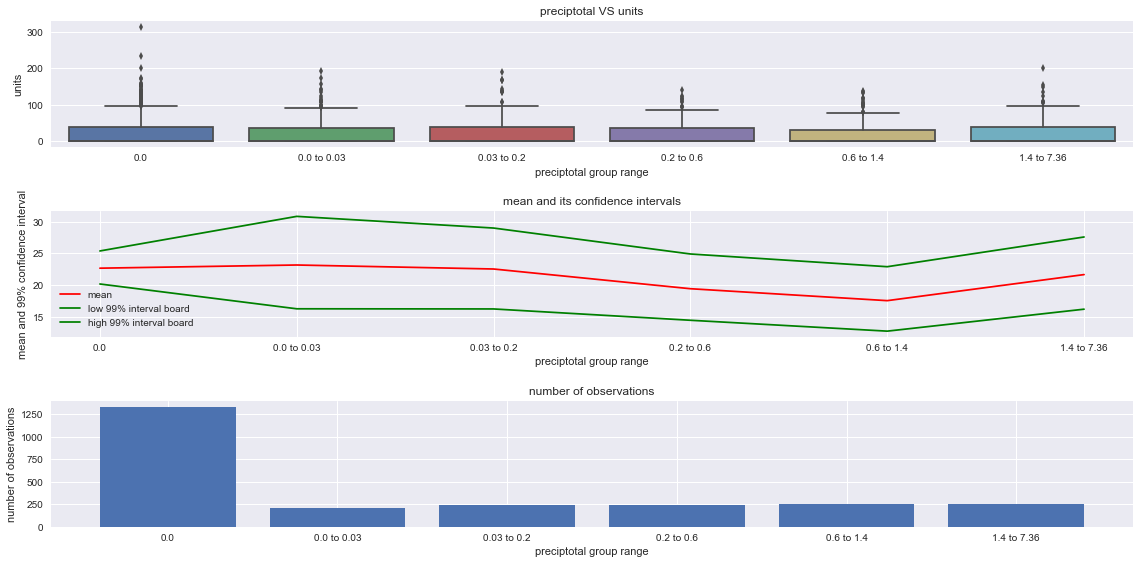

In [8]:
mask = (df_severeWeather['item_nbr'] == 5)
data = df_severeWeather.loc[mask,['units','preciptotal']]
cont_boxplot(data,'preciptotal','units',seg=10)

We can see that:

* Even close to a major weather event, the major part of days still sees no rain or snow.
* However, people seem to be more active in buying item 5 throughout the period regardless of weather condition.

We observe that people seem to like shopping more close to weather events. What about selling the record on days of major events? Let us explore:

[1.01, 1.1100000000000001, 1.3, 1.55, 2.1000000000000001, 2.8100000000000001, 7.3600000000000003]

for preciptotal range in 1.01
number of observations: 15
value,  29.2
99% interval,  [  7.466       55.93366667]

for preciptotal range in 1.01 to 1.11
number of observations: 63
value,  15.126984127
99% interval,  [  7.01579365  24.26992063]

for preciptotal range in 1.11 to 1.3
number of observations: 69
value,  22.9565217391
99% interval,  [ 12.43478261  34.92804348]

for preciptotal range in 1.3 to 1.55
number of observations: 72
value,  18.9166666667
99% interval,  [ 10.34722222  29.22229167]

for preciptotal range in 1.55 to 2.1
number of observations: 75
value,  23.5866666667
99% interval,  [ 12.9198      36.68013333]

for preciptotal range in 2.1 to 2.81
number of observations: 71
value,  22.4929577465
99% interval,  [ 12.61971831  33.67619718]

for preciptotal range in 2.81 to 7.36
number of observations: 70
value,  18.3142857143
99% interval,  [  9.4285      29.25728571]


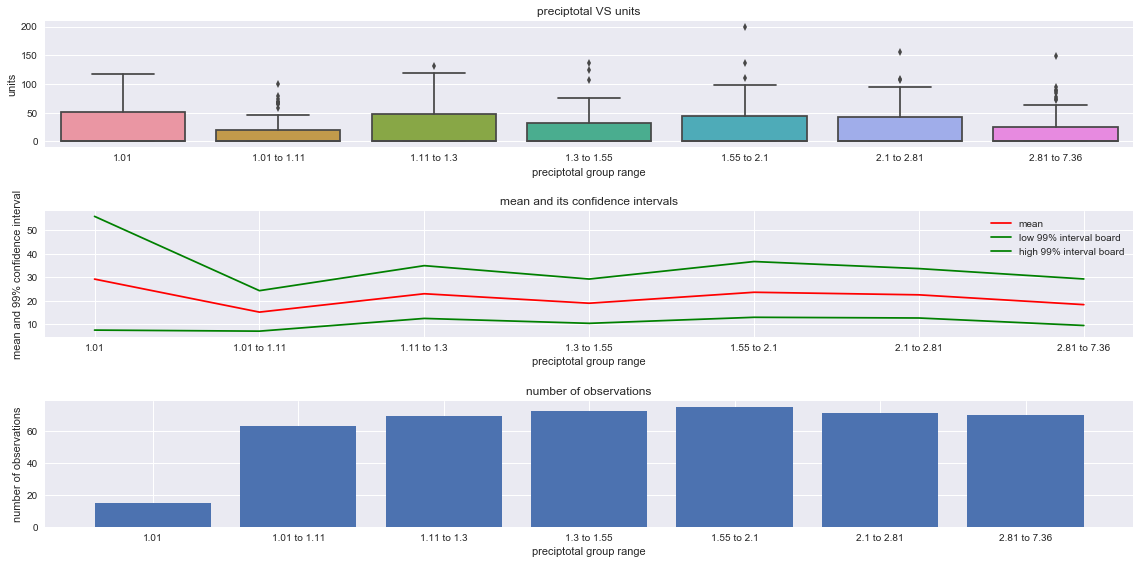

In [9]:
mask = ((df_severeWeather['item_nbr'] == 5) & (df_severeWeather['Condition']))
data = df_severeWeather.loc[mask,['units','preciptotal']]
cont_boxplot(data,'preciptotal','units',seg=6)

We can see that on the day of weather event, the selling record does not seem to differ much than the days before or after the weather event. So people just go and buy items anyway...

In conclusion, people tend to buy item 5 on a sunny day. But when facing major weather events people will go and buy them as well. Since we can indicate major events by event marker (see the part 1 report), whether a rain or snow presenting is more useful in predicting item 5 sales, but the amount of rainfall/snowfall does not matter that much.

### Tempature

Let us see how temperature affects selling:

[-16.0, 38.0, 48.0, 57.0, 64.0, 70.0, 76.0, 82.0, 100.0]

for tavg range in -16.0
number of observations: 2
value,  0.0
99% interval,  [ 0.  0.]

for tavg range in -16.0 to 38.0
number of observations: 5438
value,  18.4223979404
99% interval,  [ 17.24934903  19.56624402]

for tavg range in 38.0 to 48.0
number of observations: 4991
value,  22.957723903
99% interval,  [ 21.68943999  24.27010519]

for tavg range in 48.0 to 57.0
number of observations: 5708
value,  22.1021373511
99% interval,  [ 20.98668273  23.297839  ]

for tavg range in 57.0 to 64.0
number of observations: 4769
value,  17.7418746068
99% interval,  [ 16.59089851  18.88093625]

for tavg range in 64.0 to 70.0
number of observations: 5392
value,  16.9821958457
99% interval,  [ 15.93823999  18.01836888]

for tavg range in 70.0 to 76.0
number of observations: 5181
value,  17.1291256514
99% interval,  [ 16.11329473  18.22312584]

for tavg range in 76.0 to 82.0
number of observations: 5142
value,  21.3131077402
99% interval,  [

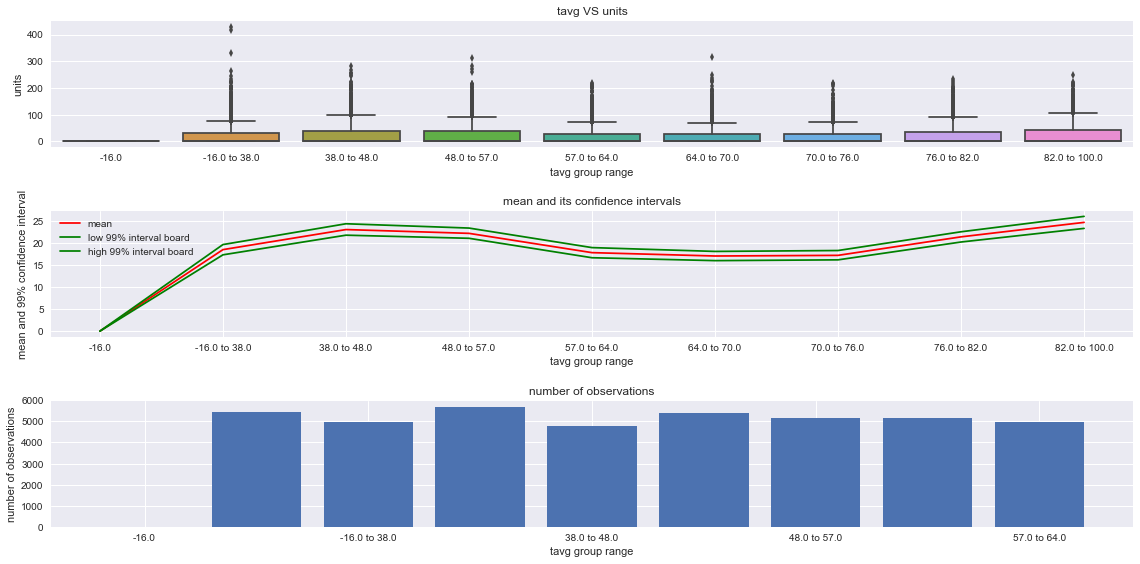

In [10]:
mask = (df_ordered['item_nbr'] == 5)
data = df_ordered.loc[mask,['units','tavg']]
cont_boxplot(data,'tavg','units',seg=8)

In normal times, it can be observed that people tend to buy less item 5 when the temperature is between -16 to 38 $^{\circ}$F, and between 64 $^{\circ}$F to 76 $^{\circ}$F. The temperature and selling record surely has a correlation in general case. However, this correlation is not linear.

Let us see how the temperature affect people during major weather events:

[4.0, 44.800000000000011, 55.0, 62.0, 68.0, 72.0, 75.0, 78.0, 80.0, 83.0, 94.0]

for tavg range in 4.0
number of observations: 1
value,  0.0
99% interval,  [ 0.  0.]

for tavg range in 4.0 to 44.8
number of observations: 253
value,  13.6324110672
99% interval,  [  9.26478261  18.63243083]

for tavg range in 44.8 to 55.0
number of observations: 289
value,  20.678200692
99% interval,  [ 15.7715917   25.78207612]

for tavg range in 55.0 to 62.0
number of observations: 249
value,  20.124497992
99% interval,  [ 14.79114458  26.1446988 ]

for tavg range in 62.0 to 68.0
number of observations: 238
value,  26.768907563
99% interval,  [ 20.04178571  34.34054622]

for tavg range in 68.0 to 72.0
number of observations: 320
value,  23.975
99% interval,  [ 18.775       29.42509375]

for tavg range in 72.0 to 75.0
number of observations: 201
value,  25.3980099502
99% interval,  [ 19.10442786  32.27865672]

for tavg range in 75.0 to 78.0
number of observations: 265
value,  19.9962264151
99% interval,

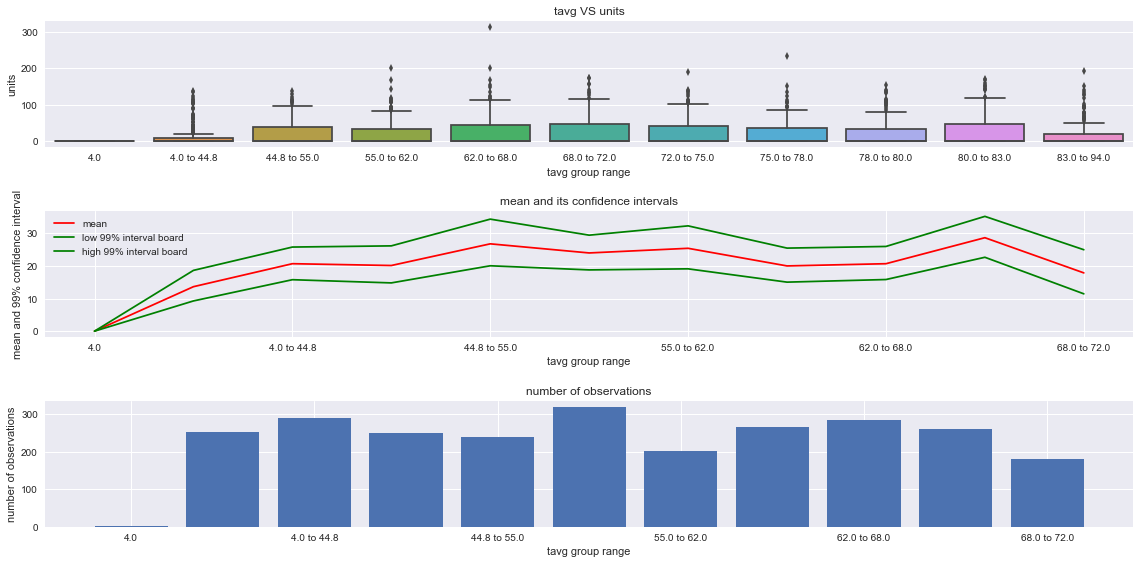

In [11]:
mask = (df_severeWeather['item_nbr'] == 5)
data = df_severeWeather.loc[mask,['units','tavg']]
cont_boxplot(data,'tavg','units',seg=10)

[24.0, 55.0, 64.0, 72.0, 78.0, 80.0, 85.5]

for tavg range in 24.0
number of observations: 2
value,  0.0
99% interval,  [ 0.  0.]

for tavg range in 24.0 to 55.0
number of observations: 79
value,  20.5949367089
99% interval,  [ 11.26575949  30.74696203]

for tavg range in 55.0 to 64.0
number of observations: 71
value,  25.9718309859
99% interval,  [ 14.56330986  39.52161972]

for tavg range in 64.0 to 72.0
number of observations: 71
value,  24.5352112676
99% interval,  [ 15.38028169  34.80295775]

for tavg range in 72.0 to 78.0
number of observations: 82
value,  16.9634146341
99% interval,  [  9.12176829  26.08536585]

for tavg range in 78.0 to 80.0
number of observations: 70
value,  16.2571428571
99% interval,  [  7.98557143  26.40007143]

for tavg range in 80.0 to 85.5
number of observations: 60
value,  20.7166666667
99% interval,  [ 10.26633333  33.21675   ]


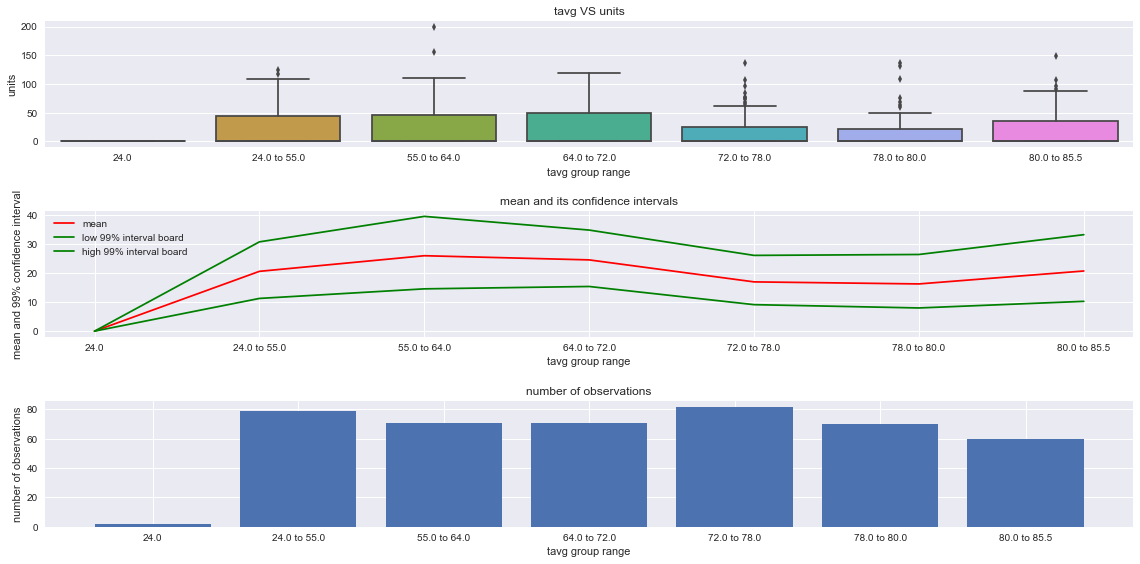

In [12]:
mask = ((df_severeWeather['item_nbr'] == 5) & (df_severeWeather['Condition']))
data = df_severeWeather.loc[mask,['units','tavg']]
cont_boxplot(data,'tavg','units',seg=6)

Because the confidence interval is large, All I can say is the correlation between temperature and selling record during major weather events is less stronger than the one during normal days.

## Conclusion

In this report, the goal is set to find which features are more dominant in predicting item 5 sales. For item 5, I observe the following:

* Year: Sales record steady goes down given the year.
* Month: The month record is more even and diverse. It is hard to find a clear pattern.
* Weekday: People tend to buy more on weekends. On weekdays, Monday and Friday see more selling than others.
* Rainfall/Snowfall: People tend to buy item 5 on a sunny day. But when facing major weather events people will go and buy them as well. 
* Temperature: It can be observed that during normal days people tend to buy less item 5 when the temperature is between -16 to 38 $^{\circ}$F, and between 64 $^{\circ}$F to 76 $^{\circ}$F. When there is a major weather event, however, the confidence interval becomes large enough to affect this conclusion from a statistical point of view. 

In conclusion (Note that they need to be tested using inferential statistics):

* Year: Year does affect the sales record.
* Month: The correlation is not as explicit.
* Weekday: Weekday does affect the sales record.
* Rainfall/Snowfall: Since we can indicate major events by event marker (see the part 1 report), whether rain/snow presents is useful in predicting item 5 sales, but the amount of rainfall/snowfall does not matter that much.
* Temperature: During normal days, The temperature and selling record surely has a correlation in general case. However, this correlation is not linear. Also, the correlation between temperature and selling record during major weather events is less stronger than the one during normal days.

If those conclusions stand, recommendations towards learning method are:

* Because of the presence of non-linear correlation, linear models, such as linear regression and SVM may not work well.
* Because of the thresholding effect of certain features (such as people just stop shopping when they see a tiny bit of rain or snow during normal days), Decision tree and Random Forests may work well.
* As shown in report 1, there might be a logical correlation between features indicating whether the day is a normal day, a day before a bad weather or a day after a bad weather. Because of this, using neuro network on this project might be promising.